### General note for GPU training (in colab)

* First, please use the GPU runtime. If so the `!nvidia-smi` will return no error.
  1. Click on "Runtime" in the top menu bar.
  2. Select "Change runtime type" from the drop-down menu.
  3. In the "Runtime type" section, select "GPU" as the hardware accelerator.
  4. Click "Save" to apply the changes.


* What should I do with **Cuda out of memory error.**? (this is THE most common error in DL)
![](https://miro.medium.com/v2/resize:fit:828/format:webp/1*enMsxkgJ1eb9XvtWju5V8Q.png)
  1. In colab notebook, **unfortunately, you need to restart the kernel after OOM happened**. Or it will keep happening no matter what.
  2. Change the model to save memory, usually includes, decrease batch size, decrease the number of layers, decrease the max sequence length, decrease the hidden / embedding dimension
  3. If you know mixed precision training, you can switch to low precision `fp16` numbers for weights and inputs.

* What should I do for the **Device siee assert triggered** error
  > RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
  
  * Usually it's because the embedding layer receive an index (token id or position id) not stored in it.
  * Could be sth. else, which will be harder to debug...

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8" # to fix a potential locale bug
!nvidia-smi

Wed Apr 19 20:35:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    33W /  70W |    633MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Imports

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 48.8 MB/s eta 0:00:00


In [ ]:
## Import transformers
from transformers import get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification
from transformers import BertModel, BertTokenizer, BertConfig
from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config, GPT2Model

import os
from os.path import join
from tqdm.notebook import tqdm, trange
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW, Adam
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST, CIFAR10
from torchvision import datasets, transforms


### Preparing Image Dataset
Load the dataset, note, the augmentations are necessary. If no augmentation, both CNN and Transformer will overfit very soon.

In [ ]:
dataset = CIFAR10(root='/content/', train=True, download=True, transform=
transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
]))
# augmentations are super important for CNN trainings, or it will overfit very fast without achieving good generalization accuracy
val_dataset = CIFAR10(root='/content/', train=False, download=True, transform=transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),]))
#%%

100%|██████████| 170498071/170498071 [00:03<00:00, 46396944.23it/s]


Extracting /content/cifar-10-python.tar.gz to /content/
Files already downloaded and verified


Citing https://openreview.net/pdf?id=SCN8UaetXx,

> Visual Transformers. Despite some previous work in which attention is used inside the convolutional layers of a CNN [57, 26], the first fully-transformer architectures for vision are iGPT [8] and ViT [17]. The former is trained using a "masked-pixel" self-supervised approach, similar in spirit to the common masked-word task used, for instance, in BERT [15] and in GPT [45] (see below). On the other hand, ViT is trained in a supervised way, using a special "class token" and a classification head attached to the final embedding of this token. Both methods are computationally expensive and, despite their very good results when trained on huge datasets, they underperform ResNet architectures when trained from scratch using only ImageNet-1K [17, 8]. VideoBERT [51] is conceptually similar to iGPT, but, rather than using pixels as tokens, each frame of a video is holistically represented by a feature vector, which is quantized using an off-the-shelf pretrained video classification model. DeiT [53] trains ViT using distillation information provided by a pretrained CNN

### Transformer model for images

In [ ]:
config = BertConfig(hidden_size=256, intermediate_size=1024, num_hidden_layers=12,
                    num_attention_heads=8, max_position_embeddings=256,
                    vocab_size=100, bos_token_id=101, eos_token_id=102,
                    cls_token_id=103, )
model = BertModel(config).cuda()
patch_embed = nn.Conv2d(3, config.hidden_size, kernel_size=4, stride=4).cuda()
CLS_token = nn.Parameter(torch.randn(1, 1, config.hidden_size, device="cuda") / math.sqrt(config.hidden_size))
readout = nn.Sequential(nn.Linear(config.hidden_size, config.hidden_size),
                        nn.GELU(),
                        nn.Linear(config.hidden_size, 10)
                        ).cuda()
for module in [patch_embed, readout, model, CLS_token]:
    module.cuda()

optimizer = AdamW([*model.parameters(),
                   *patch_embed.parameters(),
                   *readout.parameters(),
                   CLS_token], lr=5e-4)

In [ ]:
batch_size = 192 # 96
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
model.train()
for epoch in trange(50, leave=False):
    pbar = tqdm(train_loader, leave=False)
    for i, (imgs, labels) in enumerate(pbar):
        patch_embs = patch_embed(imgs.cuda())
        patch_embs = patch_embs.flatten(2).permute(0, 2, 1)  # (batch_size, HW, hidden)
        # print(patch_embs.shape)
        input_embs = torch.cat([CLS_token.expand(imgs.shape[0], 1, -1), patch_embs], dim=1)
        # print(input_embs.shape)
        output = model(inputs_embeds=input_embs)
        logit = readout(output.last_hidden_state[:, 0, :])
        loss = F.cross_entropy(logit, labels.cuda())
        # print(loss)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        pbar.set_description(f"loss: {loss.item():.4f}")

    # test on validation set
    model.eval()
    correct_cnt = 0
    total_loss = 0
    for i, (imgs, labels) in enumerate(val_loader):
        patch_embs = patch_embed(imgs.cuda())
        patch_embs = patch_embs.flatten(2).permute(0, 2, 1)  # (batch_size, HW, hidden)
        input_embs = torch.cat([CLS_token.expand(imgs.shape[0], 1, -1), patch_embs], dim=1)
        output = model(inputs_embeds=input_embs)
        logit = readout(output.last_hidden_state[:, 0, :])
        loss = F.cross_entropy(logit, labels.cuda())
        total_loss += loss.item() * imgs.shape[0]
        correct_cnt += (logit.argmax(dim=1) == labels.cuda()).sum().item()

    print(f"val loss: {total_loss / len(val_dataset):.4f}, val acc: {correct_cnt / len(val_dataset):.4f}")


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 1.3979, val acc: 0.4805


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 1.2839, val acc: 0.5377


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 1.1238, val acc: 0.5985


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 1.0975, val acc: 0.6018


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 1.1073, val acc: 0.6138


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.9169, val acc: 0.6747


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.8614, val acc: 0.6964


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.8493, val acc: 0.7011


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.7867, val acc: 0.7230


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.8073, val acc: 0.7129


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.7586, val acc: 0.7331


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.7572, val acc: 0.7396


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.7325, val acc: 0.7488


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.6610, val acc: 0.7712


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.6664, val acc: 0.7695


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.6758, val acc: 0.7617


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.6088, val acc: 0.7875


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.6353, val acc: 0.7819


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.6106, val acc: 0.7906


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.5952, val acc: 0.7996


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.6134, val acc: 0.7959


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.5842, val acc: 0.8057


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.5777, val acc: 0.8059


  0%|          | 0/261 [00:00<?, ?it/s]

val loss: 0.5894, val acc: 0.7998


  0%|          | 0/261 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
torch.save(model.state_dict(),"bert.pth")
!du -sh bert.pth

37M	bert.pth


This training can take a while but in the end it will converge to around 80% top 1 accuracy, on par with ResNet18.
```
with data augmentation, patch size: 4
batch_size = 128, lr=5e-4 (AdamW)
loss: 0.1783: 100%|███████████████████████████| 391/391 [00:40<00:00,  9.71it/s]
val loss: 0.5719, val acc: 0.8309
 86%|████████████████████████████████████▉      | 43/50 [29:29<05:07, 43.88s/it]
```

```
without data augmentation, patch size: 4 batch_size = 96, lr=5e-4 (AdamW)
loss: 0.2320: 100%|███████████████████████████| 521/521 [00:36<00:00, 14.45it/s]
val loss: 1.3631, val acc: 0.6644
100%|███████████████████████████████████████████| 25/25 [16:14<00:00, 38.97s/it]
```

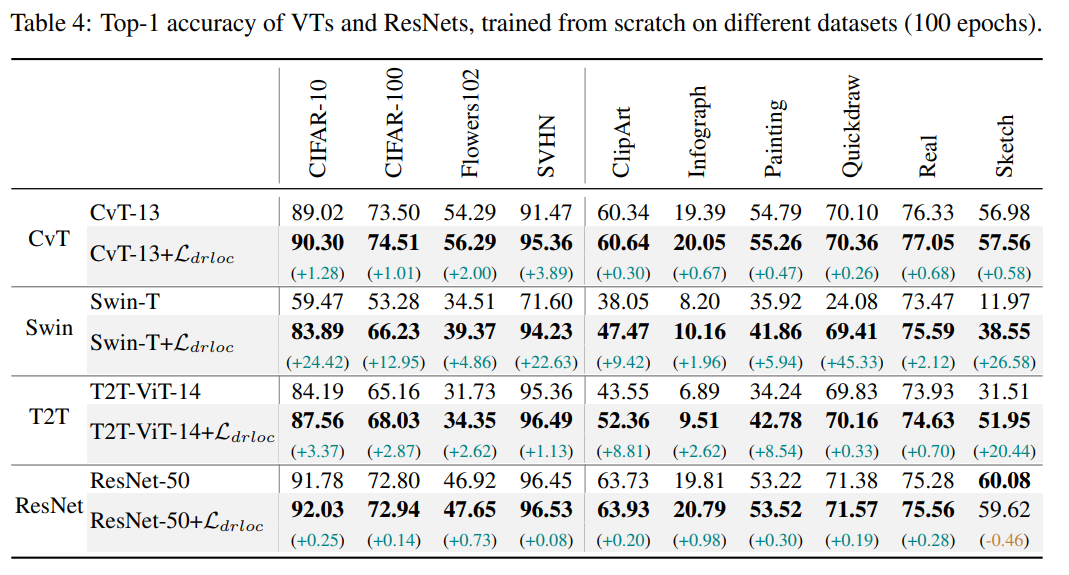

### Compare with CNN - ResNet18

In [ ]:
torch.cuda.empty_cache()

In [ ]:
from torchvision.models import resnet18
model_cnn = resnet18(pretrained=False)
model_cnn.fc = nn.Linear(512, 10)
model_cnn.cuda()
optimizer = AdamW(model_cnn.parameters(), lr=10e-4)


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
batch_size = 512 # note you can put a much larger batch for CNNs than transformer
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
for epoch in trange(50, leave=False):
    model_cnn.train()
    pbar = tqdm(train_loader, leave=False)
    for i, (imgs, labels) in enumerate(pbar):
        output = model_cnn(imgs.cuda())
        loss = F.cross_entropy(output, labels.cuda())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        pbar.set_description(f"loss: {loss.item():.4f}")

    # test on validation set
    model_cnn.eval()
    correct_cnt = 0
    total_loss = 0
    for i, (imgs, labels) in enumerate(val_loader):
        output = model_cnn(imgs.cuda())
        loss = F.cross_entropy(output, labels.cuda())
        total_loss += loss.item() * imgs.shape[0]
        correct_cnt += (output.argmax(dim=1) == labels.cuda()).sum().item()

    print(f"val loss: {total_loss / len(val_dataset):.4f}, val acc: {correct_cnt / len(val_dataset):.4f}")


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

val loss: 1.3648, val acc: 0.5103


  0%|          | 0/98 [00:00<?, ?it/s]

val loss: 1.1636, val acc: 0.5909


  0%|          | 0/98 [00:00<?, ?it/s]

val loss: 1.2241, val acc: 0.5913


  0%|          | 0/98 [00:00<?, ?it/s]

val loss: 0.9849, val acc: 0.6513


  0%|          | 0/98 [00:00<?, ?it/s]

val loss: 0.9123, val acc: 0.6814


  0%|          | 0/98 [00:00<?, ?it/s]

val loss: 0.9228, val acc: 0.6886


  0%|          | 0/98 [00:00<?, ?it/s]

val loss: 0.8419, val acc: 0.7093


  0%|          | 0/98 [00:00<?, ?it/s]

val loss: 0.7946, val acc: 0.7306


  0%|          | 0/98 [00:00<?, ?it/s]

val loss: 0.7598, val acc: 0.7400


  0%|          | 0/98 [00:00<?, ?it/s]

val loss: 0.7874, val acc: 0.7389


  0%|          | 0/98 [00:00<?, ?it/s]

val loss: 0.7269, val acc: 0.7525


  0%|          | 0/98 [00:00<?, ?it/s]

val loss: 0.7277, val acc: 0.7516


  0%|          | 0/98 [00:00<?, ?it/s]

val loss: 0.7581, val acc: 0.7476


  0%|          | 0/98 [00:00<?, ?it/s]

val loss: 0.7114, val acc: 0.7548


  0%|          | 0/98 [00:00<?, ?it/s]

val loss: 0.6454, val acc: 0.7829


  0%|          | 0/98 [00:00<?, ?it/s]

val loss: 0.7115, val acc: 0.7634


  0%|          | 0/98 [00:00<?, ?it/s]

val loss: 0.6204, val acc: 0.7924


  0%|          | 0/98 [00:00<?, ?it/s]

val loss: 0.6309, val acc: 0.7937


  0%|          | 0/98 [00:00<?, ?it/s]

val loss: 0.6015, val acc: 0.7983


  0%|          | 0/98 [00:00<?, ?it/s]

val loss: 0.6291, val acc: 0.7896


  0%|          | 0/98 [00:00<?, ?it/s]

val loss: 0.6200, val acc: 0.7924


  0%|          | 0/98 [00:00<?, ?it/s]

val loss: 0.6348, val acc: 0.7904


  0%|          | 0/98 [00:00<?, ?it/s]

val loss: 0.6543, val acc: 0.7868


  0%|          | 0/98 [00:00<?, ?it/s]

val loss: 0.6322, val acc: 0.7976


  0%|          | 0/98 [00:00<?, ?it/s]

val loss: 0.6106, val acc: 0.8021


  0%|          | 0/98 [00:00<?, ?it/s]

val loss: 0.6373, val acc: 0.7915


  0%|          | 0/98 [00:00<?, ?it/s]

val loss: 0.5913, val acc: 0.8078


  0%|          | 0/98 [00:00<?, ?it/s]

val loss: 0.6124, val acc: 0.8054


  0%|          | 0/98 [00:00<?, ?it/s]

val loss: 0.6014, val acc: 0.8072


  0%|          | 0/98 [00:00<?, ?it/s]

val loss: 0.5925, val acc: 0.8120


  0%|          | 0/98 [00:00<?, ?it/s]

val loss: 0.5966, val acc: 0.8128


  0%|          | 0/98 [00:00<?, ?it/s]

val loss: 0.5846, val acc: 0.8139


  0%|          | 0/98 [00:00<?, ?it/s]

val loss: 0.6231, val acc: 0.8109


  0%|          | 0/98 [00:00<?, ?it/s]

val loss: 0.6155, val acc: 0.8077


  0%|          | 0/98 [00:00<?, ?it/s]

val loss: 0.5904, val acc: 0.8187


  0%|          | 0/98 [00:00<?, ?it/s]

val loss: 0.6497, val acc: 0.8027


  0%|          | 0/98 [00:00<?, ?it/s]

val loss: 0.5822, val acc: 0.8206


  0%|          | 0/98 [00:00<?, ?it/s]

val loss: 0.6224, val acc: 0.8150


  0%|          | 0/98 [00:00<?, ?it/s]

val loss: 0.5888, val acc: 0.8216


  0%|          | 0/98 [00:00<?, ?it/s]

val loss: 0.6051, val acc: 0.8175


  0%|          | 0/98 [00:00<?, ?it/s]

val loss: 0.6012, val acc: 0.8200


  0%|          | 0/98 [00:00<?, ?it/s]

val loss: 0.6370, val acc: 0.8169


  0%|          | 0/98 [00:00<?, ?it/s]

val loss: 0.5972, val acc: 0.8235


  0%|          | 0/98 [00:00<?, ?it/s]

val loss: 0.6202, val acc: 0.8238


  0%|          | 0/98 [00:00<?, ?it/s]

val loss: 0.6122, val acc: 0.8215


  0%|          | 0/98 [00:00<?, ?it/s]

val loss: 0.6557, val acc: 0.8187


  0%|          | 0/98 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
torch.save(model_cnn.state_dict(),"cnn_resnet18.pth")
!du -sh cnn_resnet18.pth

43M	cnn_resnet18.pth


CNN is an architecture with strong inductive bias.
It will learn the data faster than transformer. But it's also faster to overfit.
When proper data augmentation is applied, CNN will outperform transformer.

Transformer is an architecture with weak inductive bias
It will learn the data slower / needs more compute than CNN.   

> batch size: 96, lr 1E-4
loss: 0.1894: 100%|██████████████████████████▉| 519/521 [00:13<00:00, 37.36it/s]
 96%|█████████████████████████████████████████▎ | 24/25 [06:03<00:15, 15.17s/it]
val loss: 1.9748, val acc: 0.6292

> batch size: 256, lr 10E-4
>  96%|█████████████████████████████████████████▎ | 24/25 [03:41<00:09,  9.04s/it]
> loss: 0.0179:  99%|██████████████████████████▊| 195/196 [00:07<00:00, 24.92it/s]
> val loss: 1.6367, val acc: 0.7034

> batch size: 512, lr 10E-4 with data augmentation
> batch size: 512, lr 10E-4 with data augmentation
> loss: 0.4298: 100%|█████████████████████████████| 98/98 [00:16<00:00,  6.22it/s]
> val loss: 0.6143, val acc: 0.8060
> 56%|████████████████████████                   | 28/50 [08:37<06:40, 18.21s/it]
>loss: 0.2113: 100%|█████████████████████████████| 98/98 [00:16<00:00,  6.28it/s]
> val loss: 0.6069, val acc: 0.8352
 98%|██████████████████████████████████████████▏| 49/50 [14:58<00:18, 18.13s/it]